# Data Analysis

The [parse-reuters](TODO) script converts the SGML files from the [Reuters-21578 dataset](https://archive.ics.uci.edu/ml/datasets/Reuters-21578+Text+Categorization+Collection) into the following set of tab separated (TSV) files.

* rt-vocab.tsv -- term and frequency in corpus.
* rt-text.tsv -- document-id, text, tab separated.
* rt-sent.tsv -- document-id, sentence-id, sentence.
* rt-tags.tsv -- document-id, comma-separated list of tags.

This notebook reads these files and produces distributions of sentence and document lengths, from which we determine thresholds for our network.

In [1]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np
import nltk
import os
%matplotlib inline

In [2]:
DATA_DIR = "../data"
VOCAB_FILE = os.path.join(DATA_DIR, "rt-vocab.tsv")
TEXT_FILE = os.path.join(DATA_DIR, "rt-text.tsv")
SENT_FILE = os.path.join(DATA_DIR, "rt-sent.tsv")
TAGS_FILE = os.path.join(DATA_DIR, "rt-tags.tsv")

SIMILARITY_FILE = os.path.join(DATA_DIR, "rt-sims.tsv")

## Word Counts

In [3]:
counts = []
fvocab = open(VOCAB_FILE, "rb")
for line in fvocab:
    _, count = line.strip().split("\t")
    count = int(count)
#     if count > 100:
#         continue
    counts.append(count)
fvocab.close()

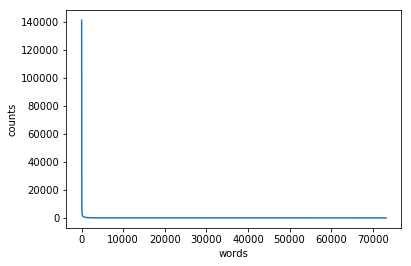

In [4]:
plt.plot(np.arange(len(counts)), counts)
plt.xlabel("words")
plt.ylabel("counts")
plt.show()

As expected, our word frequencies show the typical Zipf distribution. We cannot gain much intuition about the frequency below which to replace the word, but we will follow the [Hierarchical Attention Networks for Document Classification (PDF)](https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf) paper by Yang, et al, and set our word count threshold to replace any word that occurs 5 times or less with UNK.

## Document Length Distribution

We calculate the document length (in terms of number of sentences) for the documents in our corpus.

In [5]:
doclens = []
ftext = open(TEXT_FILE, "rb")
for line in ftext:
    _, text = line.strip().split("\t")
    num_sents = 0
    for sent in nltk.sent_tokenize(text):
        num_sents += 1
    doclens.append(num_sents)
ftext.close()

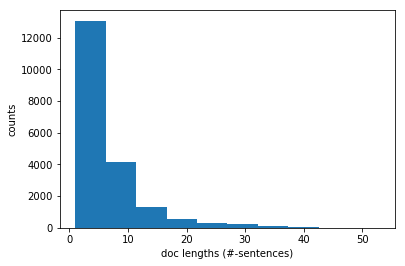

In [6]:
plt.hist(doclens, bins=10)
plt.xlabel("doc lengths (#-sentences)")
plt.ylabel("counts")
plt.show()

In [7]:
doclens_array = np.array(doclens)
for i in range(90, 100):
    print("{:d} percentile: {:.3f}".format(
        i, np.percentile(doclens_array, i)))

90 percentile: 13.000
91 percentile: 14.000
92 percentile: 14.800
93 percentile: 16.000
94 percentile: 17.000
95 percentile: 18.000
96 percentile: 20.000
97 percentile: 22.000
98 percentile: 25.000
99 percentile: 30.000


So if we set a threshold of 20 sentences per document we will cover 96% of the text, and if we set threshold of 30 sentences per document we will cover 99% of the documents.

## Sentence Length Distribution

Calculating the distribution of sentence length (in number of words) for sentences in our distribution.

In [8]:
sentlens = []
fsent = open(SENT_FILE, "rb")
for line in fsent:
    _, _, sent = line.strip().split("\t")
    num_words = 0
    for word in nltk.word_tokenize(sent):
        num_words += 1
    sentlens.append(num_words)
fsent.close()

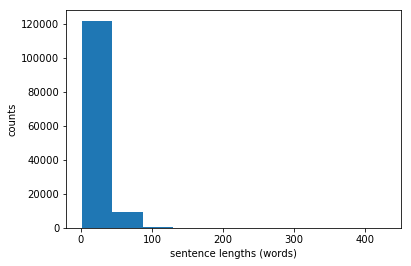

In [9]:
plt.hist(sentlens, bins=10)
plt.xlabel("sentence lengths (words)")
plt.ylabel("counts")
plt.show()

In [10]:
sentlens_array = np.array(sentlens)
for i in range(90, 100):
    print("{:d} percentile: {:.3f}".format(
        i, np.percentile(sentlens_array, i)))

90 percentile: 41.000
91 percentile: 42.000
92 percentile: 43.000
93 percentile: 44.000
94 percentile: 45.000
95 percentile: 47.000
96 percentile: 50.000
97 percentile: 53.000
98 percentile: 59.000
99 percentile: 69.000


Setting a sentence length threshold of 50 words should work for 96% of the sentences in this corpus.

## Similarity Threshold

Estimate threshold of tag similarity to consider a pair of documents similar.

Also since computing the Jaccard similarities between tags is a relatively expensive process, we will save the computed data to a file for later use.

In [11]:
tagset_list = []
ftag = open(TAGS_FILE, "rb")
for line in ftag:
    _, taglist = line.strip().split("\t")
    tagset = set()
    for tag in taglist.split(","):
        tagset.add(tag)
    tagset_list.append(tagset)
ftag.close()

In [12]:
def jaccard(a, b):
    return len(a.intersection(b)) / len(a.union(b))

fsims = open(SIMILARITY_FILE, "wb")
S = np.zeros((len(tagset_list), len(tagset_list)))
for i, tagset_a in enumerate(tagset_list):
    for j, tagset_b in enumerate(tagset_list):
        if i == j:
            S[i, j] = 1.0
            fsims.write("{:d}\t{:d}\t{:.5f}\n".format(i, j, S[i, j]))
            continue
        if i < j:
            S[i, j] = jaccard(tagset_a, tagset_b)
            S[j, i] = S[i, j]
            fsims.write("{:d}\t{:d}\t{:.5f}\n".format(i, j, S[i, j]))
            fsims.write("{:d}\t{:d}\t{:.5f}\n".format(j, i, S[j, i]))

fsims.close()

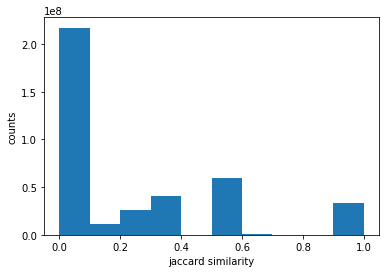

In [13]:
sims = np.ravel(S)
plt.hist(sims, bins=10)
plt.xlabel("jaccard similarity")
plt.ylabel("counts")
plt.show()

In [14]:
print(np.percentile(sims, 60))

0.2


If we choose 0.2 as our similarity threshold, then we will have 60% of the documents labeled as dissimilar and 40% as similar.